In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

from warnings import filterwarnings
filterwarnings("ignore")
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import platform
from wordcloud import WordCloud, STOPWORDS

## 1. 데이터 불러오기
- 모델2를 통해 후보자 특정한 데이터

In [6]:
df = pd.read_csv('data/취합_0407_1628_model2를 통한 후보자 예측 포함.csv', index_col=0)
df

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment,area_candidate
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,오세훈
1,2021-03-07 14:02:00,조선일보,2.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,오세훈
2,2021-03-07 13:15:00,조선일보,NaN,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...,오세훈
3,2021-03-07 12:05:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 어떻게든 문재인 정권 졸개들 박살 ...,오세훈
4,2021-03-07 10:33:00,조선일보,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 좌파 당선 도우미 안철수가 과연,오세훈
...,...,...,...,...,...,...,...,...,...
86138,2021-01-17 10:52:00,경향신문,NaN,NaN,NaN,NaN,NaN,홍준표 김종인 이제 사감 접을 때 빅 모두 포용해야 김종인 무슨 생각인가 나라를 먼...,기타
86139,2021-01-06 11:55:00,경향신문,NaN,NaN,NaN,NaN,NaN,안철수에 끌려다닐라거물 소환한 국민의힘 거물이라길래 클릭했더니 뭐냐 이건,기타
86140,2021-01-11 16:06:00,경향신문,NaN,NaN,NaN,NaN,NaN,서울특별시를 해체하는 시장이 되겠다 권수정 서울시의원 일 출마선언 부정어를 사용해서...,기타
86141,2021-01-13 10:06:00,경향신문,NaN,NaN,NaN,NaN,NaN,흑백 민주주의보수와 친여 채널 사이에 교집합은 없다아시타비는 돈이 되니까 공론의 장...,기타


In [9]:
df.info() # 우리가 사용할 데이터는 area_candidate 컬럼

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86143 entries, 0 to 86142
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            86143 non-null  object 
 1   press           86143 non-null  object 
 2   area            3295 non-null   float64
 3   party           1876 non-null   float64
 4   party_eval      1644 non-null   float64
 5   candidate       2140 non-null   float64
 6   candidate_eval  2021 non-null   float64
 7   title_comment   86143 non-null  object 
 8   area_candidate  86143 non-null  object 
dtypes: float64(5), object(4)
memory usage: 6.6+ MB


In [11]:
# 사용할 데이터 떼어내기
target_data = df[['title_comment', 'area_candidate']]
target_data

,title_comment,area_candidate
0,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,오세훈
1,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,오세훈
2,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...,오세훈
3,재보궐 부산 김영춘 박형준 서울도 양자 대결 어떻게든 문재인 정권 졸개들 박살 ...,오세훈
4,재보궐 부산 김영춘 박형준 서울도 양자 대결 좌파 당선 도우미 안철수가 과연,오세훈
...,...,...
86138,홍준표 김종인 이제 사감 접을 때 빅 모두 포용해야 김종인 무슨 생각인가 나라를 먼...,기타
86139,안철수에 끌려다닐라거물 소환한 국민의힘 거물이라길래 클릭했더니 뭐냐 이건,기타
86140,서울특별시를 해체하는 시장이 되겠다 권수정 서울시의원 일 출마선언 부정어를 사용해서...,기타
86141,흑백 민주주의보수와 친여 채널 사이에 교집합은 없다아시타비는 돈이 되니까 공론의 장...,기타


## 2. 후보별 데이터 분리하기
- 이건 정당평가나/후보평가 데이터가 없어도 가능하다.

In [14]:
# 각 후보별 데이터 분리
ys = target_data.query('area_candidate == "박영선"' )
sh = target_data.query('area_candidate == "오세훈"')
yc = target_data.query('area_candidate == "김영춘"')
hj = target_data.query('area_candidate == "박형준"')

In [16]:
# 각 후보별 데이터 개수 확인
ys.shape, sh.shape, yc.shape, hj.shape

((34481, 2), (18718, 2), (3207, 2), (3718, 2))

In [241]:
# 형용사만 분리하는 함수 생성
from konlpy.tag import Kkma

def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    adj_list = []
    for i in pos:
        if i[1] == 'Adjective':
            print(i[0], i[1])
            adj_list.append(i[0])
    return adj_list

In [46]:
# 각 후보별 '형용사'만 분리
ys_adjective = ys['title_comment'].apply(lambda x: get_pos(x))
sh_adjective = sh['title_comment'].apply(lambda x: get_pos(x))
yc_adjective = yc['title_comment'].apply(lambda x: get_pos(x))
hj_adjective = hj['title_comment'].apply(lambda x: get_pos(x))

In [145]:
# 각 후보별 '명사'만 분리
tagger = Okt()
ys_noun = tagger.nouns( ' '.join(ys['title_comment'].to_list()) )
sh_noun = tagger.nouns( ' '.join(sh['title_comment'].to_list()) )
yc_noun = tagger.nouns( ' '.join(yc['title_comment'].to_list()) )
hj_noun = tagger.nouns( ' '.join(hj['title_comment'].to_list()) )

## 3. 불용어 사전 정의 및 불용어 처리
- 출처: https://www.ranks.nl/stopwords/korean

In [251]:
# 불용어 사전
stopwords = pd.read_excel('data/한국어 불용어 사전.xlsx', header=None, names=['stopword'])
stopwords = stopwords['stopword'].to_list()

# 이다/아니다 제거
stopwords.extend(['이다','아니다','아닌가','아닌','아닐것','일것','아니라','아니겠나','입니다','아닙니다'])

# 지칭 형용사 제거
stopwords.extend(['이런','그런','저런','이것','저것','그것'])
# ※ 존재유무 형용사(있다/없다)는 for문으로 제거

In [252]:
stopwords.extend(['국민의 힘','더불어 민주당','더불어',
                  '민주당','국민','힘','사람','나라','말','놈','더',
                  '오세훈','박영선','김영춘','박형준','세훈','영선','영춘','형준',
                  '문재인','대통령','서울시장'])

In [253]:
stopwords.append('야한다')
stopwords.append('같은')

In [254]:
# 불용어 사전 확인
print(stopwords)

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [331]:
# 박영선 불용어 처리
ys_adj_list = []
for word_list in ys_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            ys_adj_list.append(word)
            
# ys_adj_list

In [332]:
# 오세훈 불용어 처리
sh_adj_list = []
for word_list in sh_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            sh_adj_list.append(word)
            
# sh_adj_list

In [333]:
# 김영춘 불용어 처리
yc_adj_list = []
for word_list in yc_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            yc_adj_list.append(word)
            
# yc_adj_list

In [334]:
# 박형준 불용어 처리
hj_adj_list = []
for word_list in hj_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            hj_adj_list.append(word)
            
# hj_adj_list

## 모델1에서 추출한 긍정/부정 형용사 사용

In [308]:
# 모델1(감성분석 모델)에서 단어별 긍정/부정 정도를 파악한 리스트 출력
import pickle
with open('data/adj_list_by_model1.pickle', 'rb') as f:
    adj_list_by_model1 = pickle.load(f)

In [309]:
# 긍정 형용사 100개
positive_adj_list = adj_list_by_model1[:100]

In [310]:
# 부정 형용사 100개
negative_adj_list = adj_list_by_model1[-100:]

## 3. Wordcloud

In [259]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import platform

In [260]:
print(platform.system())
if platform.system() == 'Windows':  
    font_path = "c:/Windows/Fonts/malgun.ttf"
else:
    pass

Windows


## 1. 박영선 후보

(-0.5, 799.5, 399.5, -0.5)

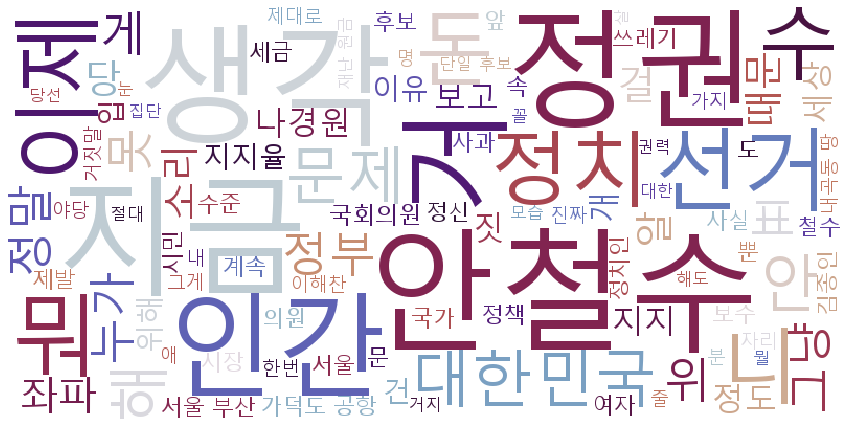

In [261]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(ys_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

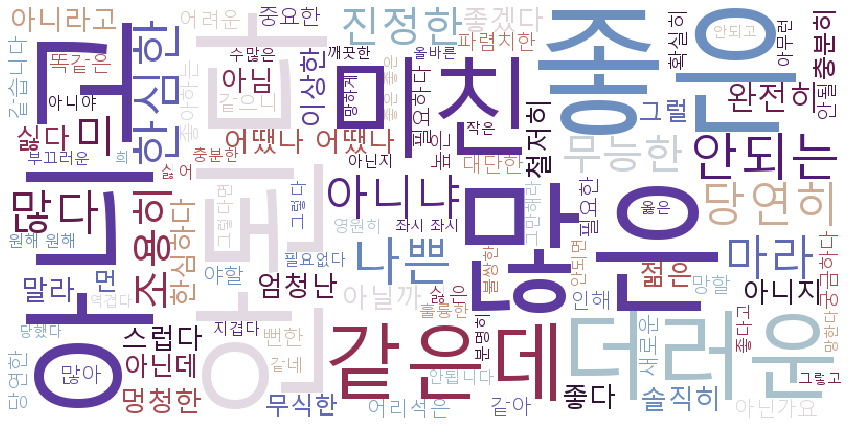

In [262]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(ys_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [318]:
# 박영선 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in ys_adj_list:
    if i in positive_adj_list:  
        yes += 1
    elif i in negative_adj_list:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
ys_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.42341220423412207


## 2. 오세훈 후보

(-0.5, 799.5, 399.5, -0.5)

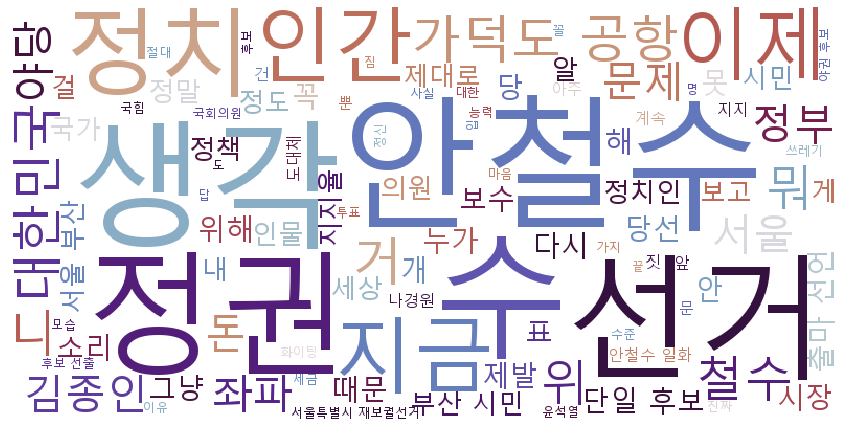

In [263]:
from wordcloud import WordCloud, STOPWORDS
stopwords
wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(sh_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

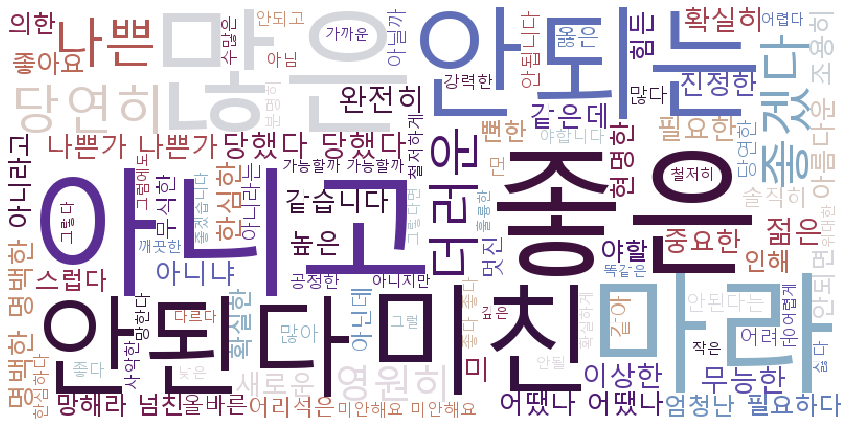

In [269]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(sh_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [317]:
# 오세훈 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in sh_adj_list:
    if i in positive_adj_list:  
        yes += 1
    elif i in negative_adj_list:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
sh_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.48038688876947877


## 3. 김영춘 후보

(-0.5, 799.5, 399.5, -0.5)

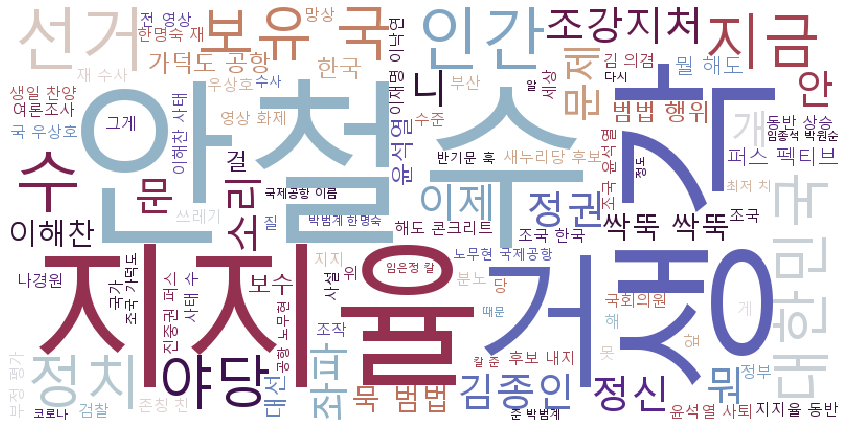

In [265]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(yc_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

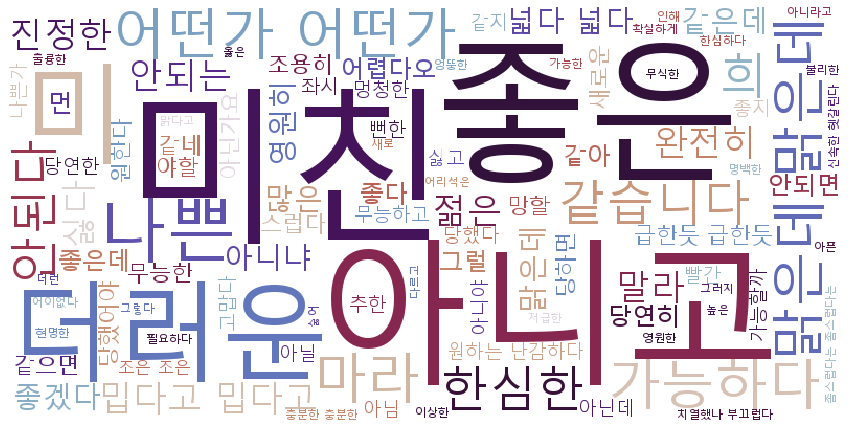

In [266]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(yc_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [316]:
# 김영춘 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in yc_adj_list:
    if i in positive_adj_list:  
        yes += 1
    elif i in negative_adj_list:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
yc_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.43351063829787234


## 4. 박형준 후보

(-0.5, 799.5, 399.5, -0.5)

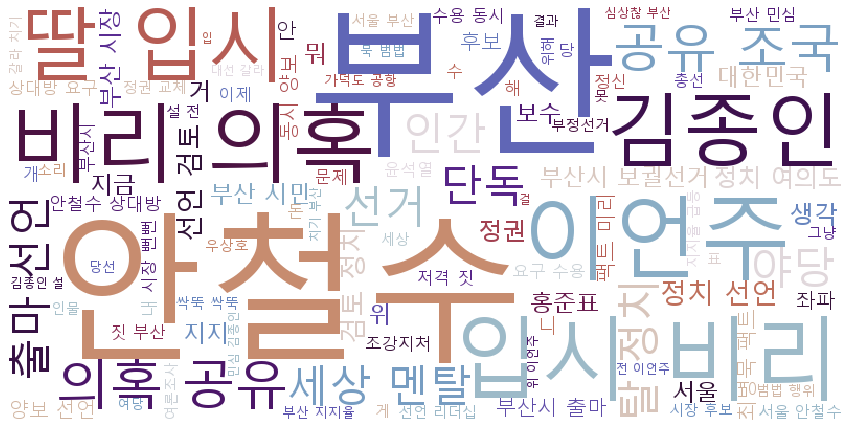

In [267]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(hj_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

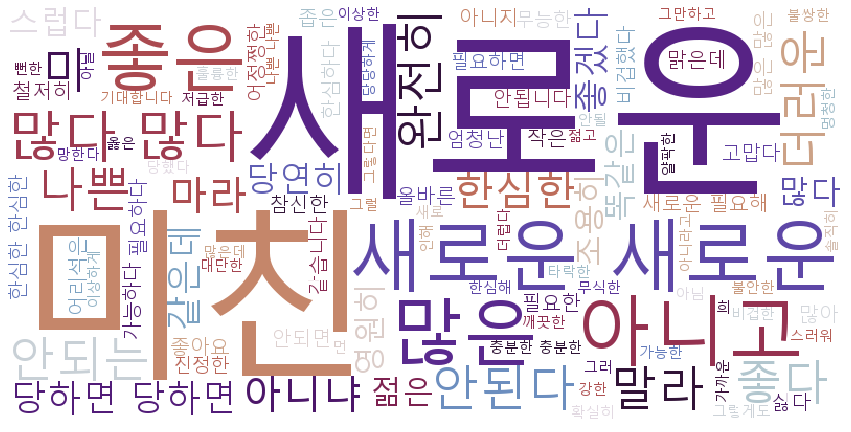

In [268]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(hj_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [315]:
# 박형준 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in hj_adj_list:
    if i in positive_adj_list:  
        yes += 1
    elif i in negative_adj_list:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
hj_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.5588652482269504


## 각 후보별 긍정 형용사 비율

- 현재까지 과정
    - 모델1에서 감성분석 진행
        - 이때 긍정/부정을 판단할 때 고려한 형태소가 무엇인지 파악했다.
        - 중요한(회귀계수가 높은) 형태소 피쳐 중 **형용사**만을 추출해 긍정/부정 형용사 단어 리스트를 저장했음

    - 모델2에서 후보자 특정 모델 생성

- 텍스트 빈도 분석
    - 모델2로 후보자를 특정한 데이터로 명사/형용사별 wordcloud형성
    - 모델1에서 저장한 **형용사 긍정/부정 단어 리스트**를 불러와 각 후보별 긍정 형용사 비율 파악


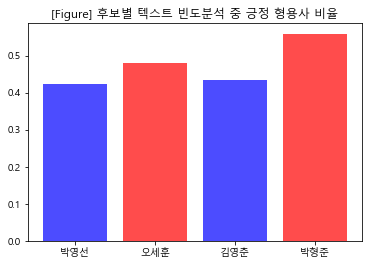

In [330]:
candidates = ['박영선','오세훈','김영춘','박형준']
plt.title('[Figure] 후보별 텍스트 빈도분석 중 긍정 형용사 비율')
plt.bar(candidates, 
        [ys_positive_ratio, sh_positive_ratio,yc_positive_ratio,hj_positive_ratio],
        color=['b','r','b','r'], alpha=0.7)
plt.show()

- 각 후보별 긍정 형용사의 비율은 큰 차이를 보이지 않음
- 그러나, 모델1을 통해 감성분석을 해본 결과 후보별 평균 긍정률은 큰 차이를 보임
- 따라서 이는 텍스트 중 형용사보다 명사나 동사 등 다른 형태소가 긍정/부정 판단에 더 영향을 준다고 이해할 수 있다